# Load Data

In [1]:
# %tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import pandas as pd
from PIL import Image
from collections import OrderedDict
from functools import partial
from random import shuffle
import matplotlib.pyplot as plt
import os
import re

np.random.seed(1)

if not os.path.exists('data'):
  !git clone https://github.com/thushv89/exercises_thushv_dot_com.git
  !cp -r ./exercises_thushv_dot_com/neural_style_transfer_light_on_math_ml/data ./data


image_size = 224
input_shape = (1, image_size, image_size, 3)

# The VGG network requires the images to be zero mean
# This the mean value of the training data of the ImageNet 
# training set, which will be used to make images zero mean
vgg_mean = [123.68, 116.779, 103.939]

# Hyperparameters used to define the final loss
alpha = 1e3
beta = 1e-3


def load_weights(weights_file, end_layer):
  """
  This function loads the weights_file and reads the weights until
  the end_layer is reached.
  """
  layers = OrderedDict()
  weights = np.load(weights_file)
  sorted_weights = sorted(weights.items())
  for i, (k, w) in enumerate(sorted_weights):
    # If we have loaded the correct number of layers we stop
    # to save memory
    if sum([1 if len(v)==2 else 0 for v in layers.values()]) >= end_layer:
      break
    if k[:-2] not in layers:
      layers[k[:-2]] = {}
    if re.search(r'conv\d+_\d+_W', k) is not None:
      layers[k[:-2]]['weights'] = w
    if re.search(r'conv\d+_\d+_b', k) is not None:
      layers[k[:-2]]['bias'] = w
    print('Loading the weights for the layer {} and shape {}'.format(k,w.shape))
  return layers

# Making sure the weights are downloaded
if not os.path.exists('vgg/vgg16_weights.npz'):
  !mkdir vgg
  !wget -O vgg/vgg16_weights.npz https://www.cs.toronto.edu/~frossard/vgg16/vgg16_weights.npz
assert_msg = 'You need to download the vgg16_weights.npz'+\
                ' file by visiting https://www.cs.toronto.edu/~frossard/vgg16/vgg16_weights.npz'+\
                ' and place that in a folder called vgg in your project directory'
assert os.path.exists(os.path.join('vgg','vgg16_weights.npz')), assert_msg

vgg_layers = load_weights(os.path.join('vgg','vgg16_weights.npz'),7)

display(vgg_layers.keys())

def get_vgg_pooling_indices(sorted_layer_ids):
  """
  A pooling layer appears at the end of each convolution group (i.e. conv<group>_<id>_W)
  """
  pool_inds = []
  prev_layer_id = int(sorted_layer_ids[0][4])
  for ki, k in enumerate(sorted_layer_ids):
    layer_id = int(k[4])
    if layer_id != prev_layer_id:
      pool_inds.append(ki-1)
    prev_layer_id = layer_id
  return pool_inds

pool_inds = get_vgg_pooling_indices(list(vgg_layers.keys()))
print('pooling indices are: {}'.format(pool_inds))

Loading the weights for the layer conv1_1_W and shape (3, 3, 3, 64)
Loading the weights for the layer conv1_1_b and shape (64,)
Loading the weights for the layer conv1_2_W and shape (3, 3, 64, 64)
Loading the weights for the layer conv1_2_b and shape (64,)
Loading the weights for the layer conv2_1_W and shape (3, 3, 64, 128)
Loading the weights for the layer conv2_1_b and shape (128,)
Loading the weights for the layer conv2_2_W and shape (3, 3, 128, 128)
Loading the weights for the layer conv2_2_b and shape (128,)
Loading the weights for the layer conv3_1_W and shape (3, 3, 128, 256)
Loading the weights for the layer conv3_1_b and shape (256,)
Loading the weights for the layer conv3_2_W and shape (3, 3, 256, 256)
Loading the weights for the layer conv3_2_b and shape (256,)
Loading the weights for the layer conv3_3_W and shape (3, 3, 256, 256)
Loading the weights for the layer conv3_3_b and shape (256,)


odict_keys(['conv1_1', 'conv1_2', 'conv2_1', 'conv2_2', 'conv3_1', 'conv3_2', 'conv3_3'])

pooling indices are: [1, 3]


In [0]:
def save_image_with_restore(image, img_mean, save_path):
  """ This function saves an image to disk """
  image_restored = image + img_mean
  image_restored = np.clip(image_restored,0,255.0)
  image_restored = image_restored.astype('uint8')
  Image.fromarray(image_restored).save(save_path)
  
def get_layer_weights(type_id, num_layers):
  """
  This function returns different layer weight schemes
  to be experimented with. 
  """
  if type_id == 0:
    weights = np.arange(1,num_layers+1)**1.5
    weights = weights/np.sum(weights)
  if type_id == 1:
    weights = np.arange(1,num_layers+1)**1.5
    weights = weights/np.sum(weights)
    weights = weights[::-1]
  return weights

(-0.5, 223.5, 223.5, -0.5)

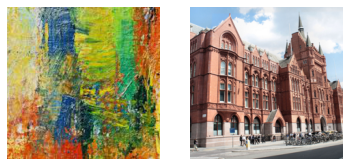

In [3]:
def image_gen_func(data_dir, file_match_str, do_shuffle=True):
  """
  This function returns a processed image and the color channel mean values.
  This is a generator function used by the tf.data api.
  """
  # Loading filenames
  files = [f for f in os.listdir(data_dir) if f.startswith(file_match_str)]
  # if do_shuffle:
  #   shuffle(files)
  
  mean = np.array([[vgg_mean]])
  
  # For each file preprocess the images and yield
  for f in files:
    img = Image.open(os.path.join(data_dir, f))
    
    width, height = img.size
    
    # We crop the image to a square by cropping on the longer axis
    if width < height:
      left,right = 0, width
      top, bottom = (height-width)/2, ((height-width)/2) + width
    elif width > height:
      top, bottom = 0, height
      left, right = (width - height)/2, ((width-height)/2) + height
    else:
      arr = np.array(img.resize((image_size,image_size))).astype(np.float32)
      yield (arr, mean)
    
    arr = np.array(img.crop((left, top, right, bottom)).resize((image_size,image_size))).astype(np.float32)
    yield (arr, mean)
  
def load_images_iterator(gen_func, zero_mean=False):
  """
  This function returns a dataset iterator of tf.data API
  """
  image_dataset = tf.data.Dataset.from_generator(
      gen_func, 
      output_types=(tf.float32, tf.float32), 
      output_shapes=(tf.TensorShape(input_shape[1:]), tf.TensorShape([1, 1, 3]))
  )
  if zero_mean:
    image_dataset = image_dataset.map(lambda x,y: (x - y, y))
  image_dataset = image_dataset.batch(1)
  return iter(image_dataset)

# Defining partial functions to used by the tf.data.Dataset.from_generator()
part_style_gen_func = partial(image_gen_func, 'data', "style_")
part_content_gen_func = partial(image_gen_func, 'data', "content_")

style_iter = load_images_iterator(part_style_gen_func, zero_mean=False)
content_iter = load_images_iterator(part_content_gen_func, zero_mean=False)

plt.imshow(Image.open(os.path.join('data','style_1.jpg')))
plt.axis('off')

next_style_image = style_iter.get_next()
next_content_image = content_iter.get_next()

plt.subplot(1,2,1)
plt.imshow(next_style_image[0][0]/255.0)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(next_content_image[0][0]/255.0)
plt.axis('off')


In [0]:
!rm -rf data/gen_*

In [5]:
# del vgg_layers # Releasing memory
from copy import deepcopy
import matplotlib.pyplot as plt

part_style_gen_func = partial(image_gen_func, 'data', "style_")
part_content_gen_func = partial(image_gen_func, 'data', "content_")

style_iter = load_images_iterator(part_style_gen_func, zero_mean=True)
content_iter = load_images_iterator(part_content_gen_func, zero_mean=True)
# generated = tf.Variable(tf.random.normal(input_shape), name="generated", trainable=True)
layer_ids = list(vgg_layers.keys())

n_iter = 500 # Number of optimizations steps per imag
models = {}

def define_style_matrix(layer_out):
  """
  This function computes the style matrix, which essentially computes
  how correlated the activations of a given filter to all the other filers.
  Therefore, if there are C channels, the matrix will be of size C x C
  """
  n_channels = layer_out.get_shape().as_list()[-1]
  unwrapped_out = tf.reshape(layer_out, [-1, n_channels])
  style_matrix = tf.matmul(unwrapped_out, unwrapped_out, transpose_a=True)
  return style_matrix

def build_vggnet(inp, layer_ids, pool_inds, on_cpu=False):
  outputs = OrderedDict()
  out = inp
  for lid in layer_ids:
    w, b = vgg_layers[lid]['weights'], vgg_layers[lid]['bias']
    out = tf.nn.conv2d(filters=w, input=out, strides=[1,1,1,1], padding='SAME')
    out = tf.nn.relu(tf.nn.bias_add(value=out, bias=b))
    outputs[lid] = out
    if lid in pool_inds:
      out = tf.nn.avg_pool(input=out, ksize=[1,2,2,1], strides=[1, 2, 2, 1], padding='SAME')
      outputs[lid.replace('conv','pool')] = out
  return outputs

for j in range(10):
  print('\nProcessing the {}th image ...'.format(j+1))
  (cont, cont_mean), (style, style_mean) = content_iter.get_next(), style_iter.get_next()
  if not os.path.exists(os.path.join('data','gen_{}'.format(j))):
    os.mkdir(os.path.join('data', 'gen_{}'.format(j)))
  save_image_with_restore(cont[0], cont_mean[0], os.path.join('data', 'gen_{}'.format(j),'content.jpg'))
  save_image_with_restore(style[0], style_mean[0], os.path.join('data', 'gen_{}'.format(j),'style.jpg'))

  opt = tf.optimizers.Adam(learning_rate=0.9)
  generated = tf.Variable(cont, name="generated", trainable=True)
  for i in range(n_iter):
    with tf.GradientTape() as tape:
      tape.watch(generated)
      # layer_weights = get_layer_weights(0, len(layer_ids))
      models['cont'] = build_vggnet(cont, layer_ids, pool_inds).values()
      models['style'] = build_vggnet(style, layer_ids, pool_inds).values()
      models['gen'] = build_vggnet(generated, layer_ids, pool_inds).values()
      lc = alpha * tf.reduce_mean(0.5*(list(models['cont'])[-1] - list(models['gen'])[-1])**2)
      c_grams = [define_style_matrix(v) for v in list(models['style'])]
      g_grams = [define_style_matrix(v) for v in list(models['gen'])]
      loss = lc + beta * tf.reduce_sum([(1.0/len(layer_ids)) * tf.reduce_mean((c - g)**2) for c,g in zip(c_grams, g_grams)])
      # loss = lc + beta * tf.reduce_sum([tf.dtypes.cast(tf.gather(layer_weights, i), tf.float32) * 0.5 * \
      #                     tf.reduce_mean((c - g)**2) for i,(c,g) in enumerate(zip(c_grams, g_grams))])
    gradients = tape.gradient(loss, generated)
    opt.apply_gradients(zip([gradients], [generated]))

    if (i+1)%50==0:
      print('\tLoss at iteration {}: {}'.format(i+1, loss))
      save_image_with_restore(generated[0], cont_mean[0], 
                              os.path.join('data', 'gen_{}'.format(j),'gen_{}.jpg'.format(i+1)))



Processing the 1th image ...
	Loss at iteration 50: 329181896376320.0
	Loss at iteration 100: 136260546985984.0
	Loss at iteration 150: 74186181574656.0
	Loss at iteration 200: 48343845699584.0
	Loss at iteration 250: 33665790771200.0
	Loss at iteration 300: 23926935650304.0
	Loss at iteration 350: 17251899015168.0
	Loss at iteration 400: 12826023297024.0
	Loss at iteration 450: 9908061732864.0
	Loss at iteration 500: 7918727462912.0

Processing the 2th image ...
	Loss at iteration 50: 8823163664203776.0
	Loss at iteration 100: 4330204549873664.0
	Loss at iteration 150: 2200736679067648.0
	Loss at iteration 200: 1098761417785344.0
	Loss at iteration 250: 545328340140032.0
	Loss at iteration 300: 298883922001920.0
	Loss at iteration 350: 192670471290880.0
	Loss at iteration 400: 139630343094272.0
	Loss at iteration 450: 107867784871936.0
	Loss at iteration 500: 86638214512640.0

Processing the 3th image ...
	Loss at iteration 50: 90369031143424.0
	Loss at iteration 100: 38287930556416.